## Time series prediction for power plants

In [22]:
import pandas as pd
from fbprophet import Prophet

In [23]:
#p50187 = pd.read_csv('plantid50187.csv')
df2016_nyiso = pd.read_csv('nyiso_2016.csv', parse_dates=['time_stamp'])
df2017_nyiso = pd.read_csv('nyiso_2017.csv', parse_dates=['time_stamp'])

In [24]:
df_nyiso = pd.concat([df2016_nyiso, df2017_nyiso], axis = 0)
df_nyiso.shape

(13127, 3)

In [25]:
df_nyiso.head()

,time_stamp,integrated_load,time_stamp_local
0,2016-01-01 05:00:00,4894.5,2016-01-01 00:00:00
1,2016-01-01 06:00:00,4712.7,2016-01-01 01:00:00
2,2016-01-01 07:00:00,4510.4,2016-01-01 02:00:00
3,2016-01-01 08:00:00,4368.4,2016-01-01 03:00:00
4,2016-01-01 09:00:00,4286.8,2016-01-01 04:00:00


In [26]:
df_nyiso.drop('time_stamp_local', axis = 1, inplace = True)
df_nyiso.columns = ['ds', 'y']

In [27]:
df_nyiso.tail()

,ds,y
4338,2017-06-30 23:00:00,8424.4
4339,2017-07-01 00:00:00,8208.2
4340,2017-07-01 01:00:00,8079.9
4341,2017-07-01 02:00:00,7788.5
4342,2017-07-01 03:00:00,7361.3


(736328.0, 736332.0)

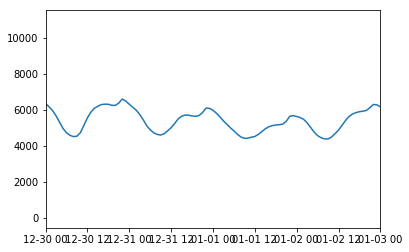

In [28]:
plt.plot(df_nyiso.iloc[:,0], df_nyiso.iloc[:,1])
plt.xlim(pd.datetime(2016,12,30), pd.datetime(2017,1,3))

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


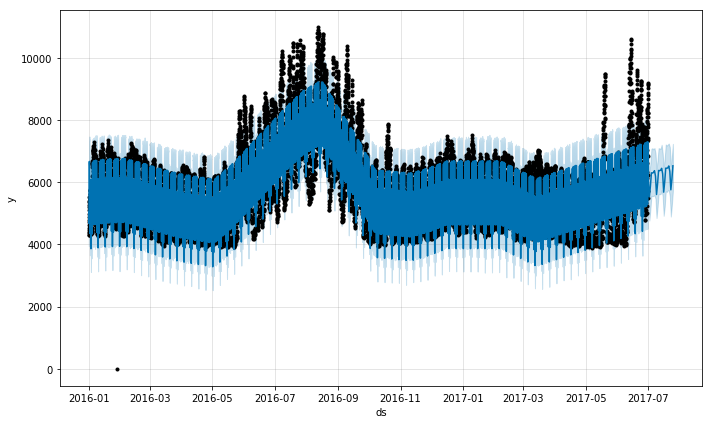

In [29]:
m = Prophet()
m.fit(df_nyiso);
future = m.make_future_dataframe(periods=24)
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

m.plot(forecast);

In [30]:
forecast.to_csv('forecast' + 'nyiso_2016_2017.csv', index = False)

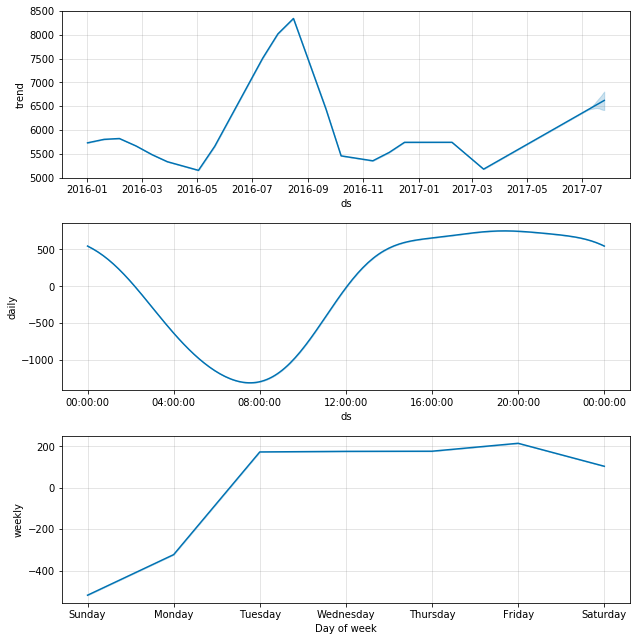

In [31]:
m.plot_components(forecast);

In [17]:
p3845 = pd.read_csv('plantid3845.csv')
p3845.columns = ['ds', 'y']

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


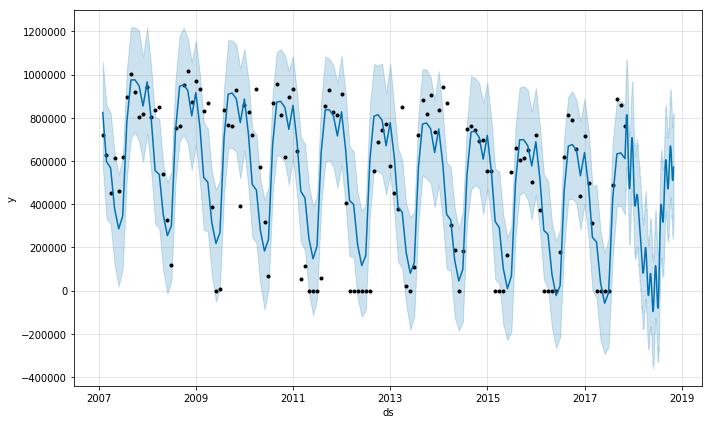

In [18]:
m = Prophet()
m.fit(p3845);
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

In [19]:
forecast.to_csv('forecast' + 'plantid3845.csv', index = False)

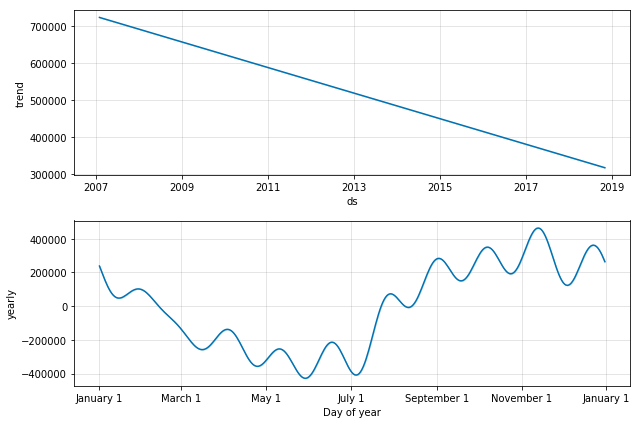

In [20]:
m.plot_components(forecast);

In [21]:
p54268 = pd.read_csv('plantid54268.csv')
p54268.columns = ['ds', 'y']

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


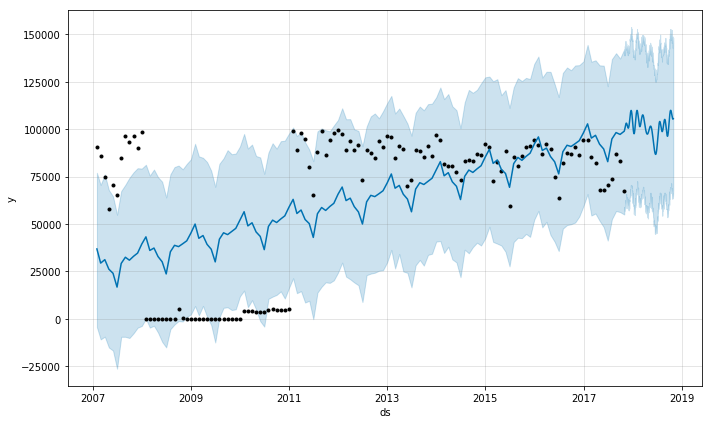

In [22]:
m = Prophet()
m.fit(p54268);
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

In [23]:
forecast.to_csv('forecast' + 'plantid54268.csv', index = False)

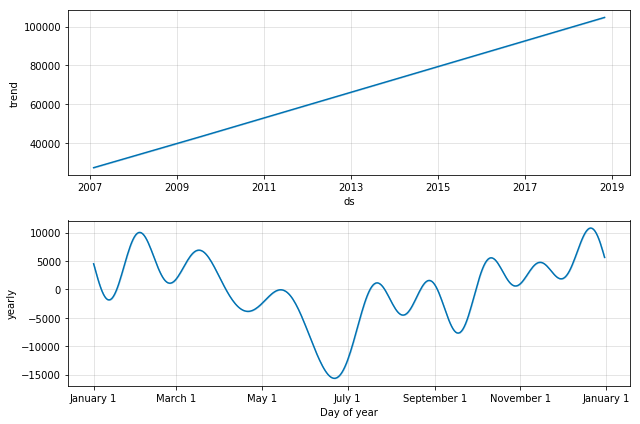

In [24]:
m.plot_components(forecast);